In [1]:
import xml.etree.ElementTree as ET

def parse_voc_annotation(xml_path):
    """
    Parses a Pascal VOC XML file and returns bounding boxes and labels.
    Returns:
        boxes: List of [xmin, ymin, xmax, ymax]
        labels: List of class names
    """
    tree = ET.parse(xml_path)
    root = tree.getroot()
    
    boxes = []
    labels = []

    for obj in root.findall("object"):
        label = obj.find("name").text.strip().lower()
        bbox = obj.find("bndbox")
        xmin = int(float(bbox.find("xmin").text))
        ymin = int(float(bbox.find("ymin").text))
        xmax = int(float(bbox.find("xmax").text))
        ymax = int(float(bbox.find("ymax").text))
        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label)
    
    return boxes, labels

In [2]:
xml_path = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/reference_annotations/Amandina.xml"
boxes, labels = parse_voc_annotation(xml_path)
print("Boxes:", boxes)
print("Labels:", labels)

Boxes: [[2672, 2131, 3641, 2721]]
Labels: ['amandina']


In [3]:
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import cv2
import os

class ChocolateDataset(Dataset):
    def __init__(self, image_dir, annotation_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))])
        self.transform = transform or transforms.Compose([
            transforms.ToPILImage(),
            transforms.Resize(target_size),
            transforms.ToTensor()
        ])
        self.target_size = target_size

        # Define your label mapping here
        self.label_to_idx = {
            'amandia': 1,
            'arabia': 2,
            'comtesse': 3,
            'creme_brulee': 4,
            'jelly_black': 5,
            'jelly_milk': 6,
            'jelly_white': 7,
            'noblesse': 8,
            'noir': 9,
            'paisson': 10,
            'stracciatella': 11,
            'tentation_noir': 12,
            'triangolo': 13
        }

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image
        image_name = self.image_files[idx]
        image_path = os.path.join(self.image_dir, image_name)
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Get original image size
        orig_h, orig_w = img.shape[:2]
        resize_h, resize_w = self.target_size

        # Load and scale annotation
        xml_name = os.path.splitext(image_name)[0] + ".xml"
        xml_path = os.path.join(self.annotation_dir, xml_name)
        boxes, labels = parse_voc_annotation(xml_path)

        # Scale bounding boxes
        scale_x = resize_w / orig_w
        scale_y = resize_h / orig_h
        scaled_boxes = []
        for box in boxes:
            xmin, ymin, xmax, ymax = box
            xmin *= scale_x
            xmax *= scale_x
            ymin *= scale_y
            ymax *= scale_y
            scaled_boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.tensor(scaled_boxes, dtype=torch.float32)

        # Convert labels to indices
        numeric_labels = [self.label_to_idx.get(lbl.lower(), 0) for lbl in labels]
        labels = torch.tensor(numeric_labels, dtype=torch.int64)

        # Resize and transform image
        img = cv2.resize(img, (resize_w, resize_h))
        img = self.transform(img)

        target = {
            'boxes': boxes,
            'labels': labels
        }

        return img, target

In [4]:
dataset = ChocolateDataset(
    image_dir="/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/references", 
    annotation_dir="/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/reference_annotations"
)

img, target = dataset[0]
print("Image shape:", img.shape)
print("Boxes:", target['boxes'])
print("Labels:", target['labels'])

Image shape: torch.Size([3, 256, 256])
Boxes: tensor([[114.0053, 136.3840, 155.3493, 174.1440]])
Labels: tensor([0])


In [5]:
import os
import cv2
import torch
from torchvision import transforms
from tqdm import tqdm

def extract_chocolate_crops(image_dir, annotation_dir, output_dir, size=(64, 64)):
    os.makedirs(output_dir, exist_ok=True)
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(size),
        transforms.ToTensor()
    ])

    image_files = [f for f in os.listdir(image_dir) if f.lower().endswith((".jpg", ".png", ".jpeg"))]
    count = 0
    for img_file in tqdm(image_files):
        img_path = os.path.join(image_dir, img_file)
        xml_path = os.path.join(annotation_dir, os.path.splitext(img_file)[0] + ".xml")

        # Load image and annotation
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        boxes, labels = parse_voc_annotation(xml_path)

        for i, (box, label) in enumerate(zip(boxes, labels)):
            xmin, ymin, xmax, ymax = [int(b) for b in box]
            crop = img[ymin:ymax, xmin:xmax]

            # Resize and transform
            crop_tensor = transform(crop)
            
            # Save as tensor file or image
            torch.save(crop_tensor, os.path.join(output_dir, f"{label}_{count}.pt"))
            count += 1

In [6]:
extract_chocolate_crops(
    image_dir="/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/references", 
    annotation_dir="/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/reference_annotations",
    output_dir="/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates",
    size=(64, 64)
)

100%|██████████| 13/13 [00:01<00:00, 12.24it/s]


In [7]:
from torch.utils.data import Dataset
import torch
import os

class ChocolateCropDataset(Dataset):
    def __init__(self, crop_dir):
        self.crop_dir = crop_dir
        self.files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])

        # Dynamically map class names to indices
        all_labels = sorted(set(f.split("_")[0] for f in self.files))
        self.label_to_idx = {name: i for i, name in enumerate(all_labels)}
        self.idx_to_label = {i: name for name, i in self.label_to_idx.items()}

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file = self.files[idx]
        path = os.path.join(self.crop_dir, file)
        tensor = torch.load(path)
        label_name = file.split("_")[0]
        label = self.label_to_idx[label_name]
        return tensor, label

In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models

# Very simple CNN (you can expand it later)
class ChocolateClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),
            nn.Flatten(),
            nn.Linear(64 * 16 * 16, 128), nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.net(x)

# Load dataset
dataset = ChocolateCropDataset("/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates")
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

# Initialize model
num_classes = len(dataset.label_to_idx)
model = ChocolateClassifier(num_classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train loop
for epoch in range(10):  # You can increase epochs
    total_loss = 0
    correct = 0
    total = 0
    model.train()
    
    for imgs, labels in dataloader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = outputs.argmax(dim=1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    acc = correct / total
    print(f"Epoch {epoch+1} - Loss: {total_loss:.4f} - Accuracy: {acc:.2f}")

Epoch 1 - Loss: 10.6846 - Accuracy: 0.00
Epoch 2 - Loss: 9.5342 - Accuracy: 0.23
Epoch 3 - Loss: 9.5823 - Accuracy: 0.08
Epoch 4 - Loss: 9.5831 - Accuracy: 0.23
Epoch 5 - Loss: 9.5621 - Accuracy: 0.31
Epoch 6 - Loss: 9.3373 - Accuracy: 0.23
Epoch 7 - Loss: 9.2870 - Accuracy: 0.23
Epoch 8 - Loss: 9.1642 - Accuracy: 0.23
Epoch 9 - Loss: 8.8268 - Accuracy: 0.23
Epoch 10 - Loss: 8.7938 - Accuracy: 0.23


In [9]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def sliding_window_detect(model, image_path, label_map, window_size=(64, 64), stride=32, threshold=0.9):
    model.eval()
    device = next(model.parameters()).device

    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(window_size),
        transforms.ToTensor()
    ])

    detections = []

    # Slide window
    for y in range(0, h - window_size[1] + 1, stride):
        for x in range(0, w - window_size[0] + 1, stride):
            patch = img_rgb[y:y+window_size[1], x:x+window_size[0]]
            patch_tensor = transform(patch).unsqueeze(0).to(device)

            with torch.no_grad():
                output = model(patch_tensor)
                probs = torch.softmax(output, dim=1)
                conf, pred = torch.max(probs, dim=1)

                if conf.item() >= threshold and pred.item() != 0:  # Ignore unknowns
                    label = label_map[pred.item()]
                    detections.append((x, y, label, conf.item()))
    print(detections)
    # Plot results
    fig, ax = plt.subplots(1, figsize=(12, 10))
    ax.imshow(img_rgb)

    for (x, y, label, score) in detections:
        rect = patches.Rectangle((x, y), window_size[0], window_size[1], linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        ax.text(x, y - 5, f"{label} ({score:.2f})", color='red', fontsize=8, backgroundcolor='white')

    plt.title("Detected Chocolates")
    plt.axis('off')
    plt.show()

    return detections

[]


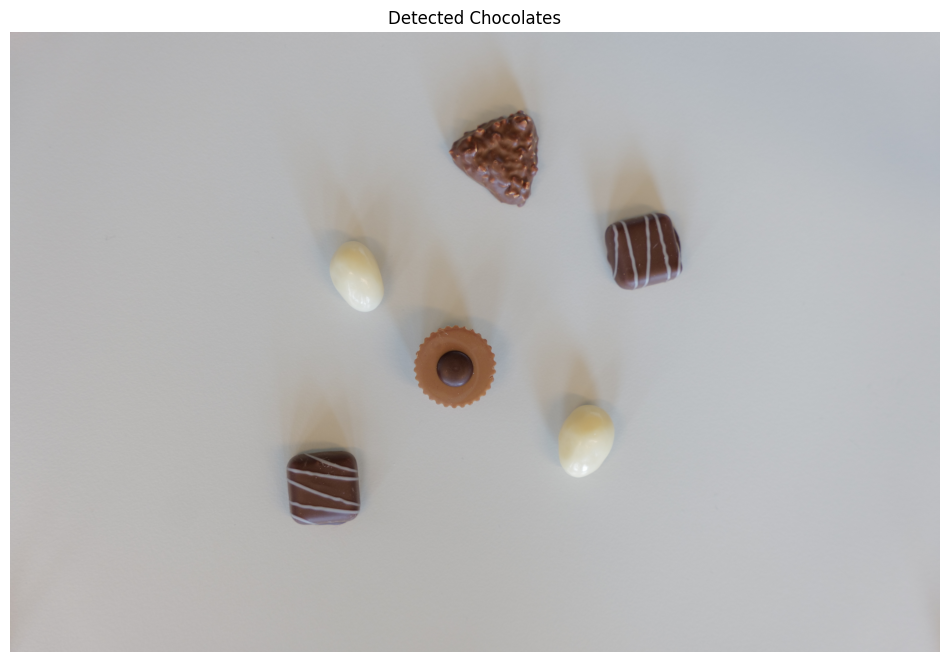

In [10]:
scene_image = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
detections = sliding_window_detect(
    model=model,
    image_path=scene_image,
    label_map=dataset.idx_to_label,
    window_size=(64, 64),
    stride=32,
    threshold=0.6  # Adjust based on confidence
)

NEW

In [11]:
import torch.nn as nn

class ChocolateEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 32x32
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2),  # 16x16
            nn.Conv2d(64, 128, 3, padding=1), nn.ReLU(), nn.AdaptiveAvgPool2d(1),  # 1x1
            nn.Flatten(),
            nn.Linear(128, embedding_dim)
        )

    def forward(self, x):
        return self.net(x)


In [12]:
import random
from torchvision import transforms

class ChocolateTripletDataset(Dataset):
    def __init__(self, crop_dir, transform=None):
        self.crop_dir = crop_dir
        self.files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])

        self.label_to_files = {}
        for f in self.files:
            label = f.split("_")[0]
            self.label_to_files.setdefault(label, []).append(f)

        self.labels = list(self.label_to_files.keys())
        self.transform = transform or transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
        ])

    def __len__(self):
        return 5000  # generate 5000 random triplets on-the-fly

    def __getitem__(self, _):
        anchor_label = random.choice(self.labels)
        anchor_files = self.label_to_files[anchor_label]
        anchor_file = random.choice(anchor_files)

        # Positive: another from same label or augmented version
        pos_file = anchor_file
        while pos_file == anchor_file and len(anchor_files) > 1:
            pos_file = random.choice(anchor_files)

        # Negative: from a different label
        neg_label = random.choice([l for l in self.labels if l != anchor_label])
        neg_file = random.choice(self.label_to_files[neg_label])

        # Load all 3 crops
        anchor = torch.load(os.path.join(self.crop_dir, anchor_file))
        positive = torch.load(os.path.join(self.crop_dir, pos_file))
        negative = torch.load(os.path.join(self.crop_dir, neg_file))

        # Apply augmentation
        anchor = self.transform(anchor)
        positive = self.transform(positive)
        negative = self.transform(negative)

        return anchor, positive, negative


In [13]:
import torch.nn.functional as F

class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Euclidean distances
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        
        # Loss: max(0, d(a,p) - d(a,n) + margin)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()


In [14]:
from torch.utils.data import DataLoader

# Setup
embedding_dim = 128
embedding_model = ChocolateEmbeddingNet(embedding_dim=embedding_dim)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
embedding_model = embedding_model.to(device)

# Dataset and loader
triplet_dataset = ChocolateTripletDataset("/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates")
triplet_loader = DataLoader(triplet_dataset, batch_size=16, shuffle=True)

# Optimizer and loss
optimizer = torch.optim.Adam(embedding_model.parameters(), lr=1e-3)
criterion = TripletLoss(margin=1.0)

# Training loop
num_epochs = 10

for epoch in range(num_epochs):
    embedding_model.train()
    total_loss = 0

    for anchor, positive, negative in triplet_loader:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)

        anchor_embed = embedding_model(anchor)
        pos_embed = embedding_model(positive)
        neg_embed = embedding_model(negative)

        loss = criterion(anchor_embed, pos_embed, neg_embed)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(triplet_loader)
    print(f"Epoch {epoch+1}: Loss = {avg_loss:.4f}")


Epoch 1: Loss = 0.1654
Epoch 2: Loss = 0.0681
Epoch 3: Loss = 0.0138
Epoch 4: Loss = 0.0170
Epoch 5: Loss = 0.0085
Epoch 6: Loss = 0.0040
Epoch 7: Loss = 0.0091
Epoch 8: Loss = 0.0067
Epoch 9: Loss = 0.0074
Epoch 10: Loss = 0.0041


In [15]:
def compute_reference_embeddings(model, crop_dir, device):
    model.eval()
    files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])
    label_to_embeddings = {}

    with torch.no_grad():
        for f in files:
            label = f.split("_")[0]
            crop = torch.load(os.path.join(crop_dir, f)).unsqueeze(0).to(device)
            embedding = model(crop).squeeze().cpu()

            label_to_embeddings.setdefault(label, []).append(embedding)

    # Average embeddings for each class
    reference_embeddings = {
        label: torch.stack(embeds).mean(dim=0) for label, embeds in label_to_embeddings.items()
    }
    return reference_embeddings


In [16]:
ref_embeds = compute_reference_embeddings(embedding_model, "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates", device)


In [19]:
from torchvision import transforms
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torch.nn.functional as F

def detect_chocolates_in_scene(model, reference_embeddings, image_path, device,
                                window_size=64, stride=32, threshold=0.9):
    model.eval()
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]

    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((window_size, window_size)),
        transforms.ToTensor()
    ])

    detection_scores = []

    with torch.no_grad():
        for y in range(0, h - window_size + 1, stride):
            for x in range(0, w - window_size + 1, stride):
                patch = img_rgb[y:y+window_size, x:x+window_size]
                patch_tensor = transform(patch).unsqueeze(0).to(device)
                patch_embed = model(patch_tensor)

                for label, ref_embed in reference_embeddings.items():
                    sim = F.cosine_similarity(patch_embed, ref_embed.unsqueeze(0)).item()
                    if sim >= threshold:
                        detection_scores.append((sim, x, y, label))

    # Sort all by similarity and keep top 20
    top_matches = sorted(detection_scores, key=lambda t: t[0], reverse=True)[:20]
    detections = [(x, y, label, sim) for sim, x, y, label in top_matches]


    # Draw detections
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_rgb)

    for (x, y, label, score) in detections:
        ax.add_patch(patches.Rectangle((x, y), window_size, window_size,
                                       linewidth=2, edgecolor='lime', facecolor='none'))
        ax.text(x, y - 5, f"{label} ({score:.2f})", color='black',
                fontsize=8, backgroundcolor='lime')

    plt.title("Chocolate Detections")
    plt.axis('off')
    plt.show()

    return detections


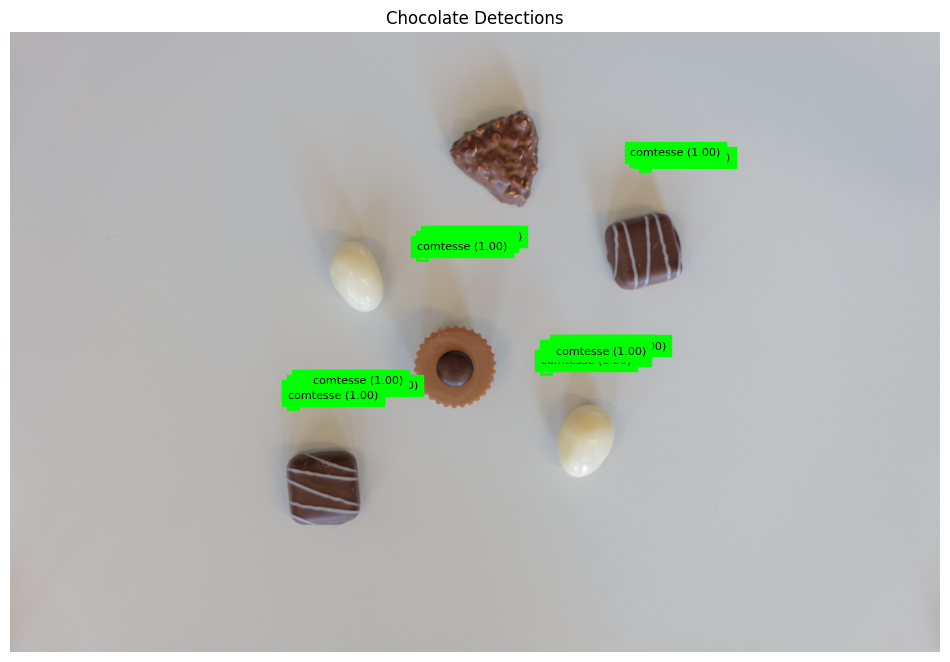

In [20]:
scene_path = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
detections = detect_chocolates_in_scene(
    model=embedding_model,
    reference_embeddings=ref_embeds,
    image_path=scene_path,
    device=device,
    window_size=64,
    stride=32,
    threshold=0.75  # Try 0.7–0.9 range
)


In [21]:
import torch.nn as nn
import torchvision.models as models

class ChocolateEmbeddingNet(nn.Module):
    def __init__(self, embedding_dim=128):
        super().__init__()
        # Use a pretrained ResNet as the backbone
        base_model = models.resnet18(pretrained=True)
        # Remove the classification layer
        self.backbone = nn.Sequential(*list(base_model.children())[:-1])
        # Add embedding projection layer
        self.embedding = nn.Linear(512, embedding_dim)
        # Add normalization layer to ensure embeddings have unit norm
        self.norm = nn.LayerNorm(embedding_dim)
        
    def forward(self, x):
        x = self.backbone(x)
        x = x.view(x.size(0), -1)
        x = self.embedding(x)
        x = self.norm(x)
        return x

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HardMiningTripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin
        
    def forward(self, embeddings, labels):
        # Get the pairwise distance matrix
        dist_matrix = torch.cdist(embeddings, embeddings)
        
        triplet_loss = 0.0
        valid_triplets = 0
        
        for i, anchor_label in enumerate(labels):
            # Find positive examples (same class)
            pos_indices = (labels == anchor_label).nonzero(as_tuple=True)[0]
            pos_indices = pos_indices[pos_indices != i]  # exclude the anchor itself
            
            # Find negative examples (different classes)
            neg_indices = (labels != anchor_label).nonzero(as_tuple=True)[0]
            
            # Skip if no valid positives or negatives
            if len(pos_indices) == 0 or len(neg_indices) == 0:
                continue
                
            # Get hardest positive (furthest same class)
            hardest_positive = dist_matrix[i, pos_indices].max()
            
            # Get hardest negative (closest different class)
            hardest_negative = dist_matrix[i, neg_indices].min()
            
            # Compute triplet loss for this anchor
            loss = F.relu(hardest_positive - hardest_negative + self.margin)
            triplet_loss += loss
            valid_triplets += 1
        
        # Return average loss over valid triplets
        if valid_triplets == 0:
            return torch.tensor(0.0, device=embeddings.device, requires_grad=True)
        return triplet_loss / valid_triplets

In [23]:
from torch.utils.data import Dataset, DataLoader
import os
import torch
from torchvision import transforms
import random

class ChocolateEmbeddingDataset(Dataset):
    def __init__(self, crop_dir, transform=None):
        self.crop_dir = crop_dir
        self.files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])
        
        # Group files by class
        self.label_to_files = {}
        for f in self.files:
            label = f.split("_")[0]
            self.label_to_files.setdefault(label, []).append(f)
            
        # Keep track of all labels and indices
        self.labels = []
        self.file_paths = []
        
        for i, f in enumerate(self.files):
            label = f.split("_")[0]
            self.labels.append(label)
            self.file_paths.append(os.path.join(crop_dir, f))
            
        self.labels_to_idx = {label: idx for idx, label in enumerate(sorted(set(self.labels)))}
        self.numeric_labels = [self.labels_to_idx[label] for label in self.labels]
        
        # Transforms
        self.transform = transform or transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)
        ])
        
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.numeric_labels[idx]
        
        tensor = torch.load(file_path)
        if self.transform:
            tensor = self.transform(tensor)
            
        return tensor, label

In [24]:
import cv2
import numpy as np

def preprocess_background(image):
    """
    Preprocess the image to reduce background noise and improve chocolate detection.
    """
    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
    
    # Apply bilateral filter to preserve edges
    filtered = cv2.bilateralFilter(gray, 11, 50, 50)
    
    # Apply adaptive thresholding
    thresh = cv2.adaptiveThreshold(
        filtered, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
        cv2.THRESH_BINARY_INV, 15, 2)
    
    # Morphological operations to clean up noise
    kernel = np.ones((5, 5), np.uint8)
    cleaned = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=1)
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, kernel, iterations=2)
    
    # Find contours and filter by area
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create mask for potential objects
    mask = np.zeros_like(gray)
    
    # Draw contours that might be chocolates (filter by size)
    min_area = 500
    for contour in contours:
        if cv2.contourArea(contour) > min_area:
            cv2.drawContours(mask, [contour], -1, 255, -1)
    
    # Apply mask to the original image
    result = image.copy()
    result[mask == 0] = [0, 0, 0]  # Set background to black
    
    return result

In [25]:
def train_embedding_model(model, dataset, num_epochs=30, batch_size=16, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create data loader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create loss function
    criterion = HardMiningTripletLoss(margin=0.5)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            # Forward pass
            embeddings = model(inputs)
            
            # Compute loss
            loss = criterion(embeddings, labels)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
        
        # Print statistics
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    print("Training complete!")
    return model

In [26]:
def compute_reference_embeddings(model, crop_dir, device):
    """
    Compute embeddings for all reference chocolate images.
    """
    model.eval()
    files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])
    label_to_embeddings = {}
    
    with torch.no_grad():
        for f in files:
            label = f.split("_")[0]
            crop = torch.load(os.path.join(crop_dir, f)).unsqueeze(0).to(device)
            embedding = model(crop).squeeze().cpu()
            
            if label not in label_to_embeddings:
                label_to_embeddings[label] = []
            label_to_embeddings[label].append(embedding)
    
    # Average embeddings for each class
    reference_embeddings = {}
    for label, embeds in label_to_embeddings.items():
        reference_embeddings[label] = torch.stack(embeds).mean(dim=0)
    
    return reference_embeddings

In [27]:
def non_max_suppression(detections, iou_threshold=0.5):
    """
    Apply non-maximum suppression to remove overlapping detections.
    
    Args:
        detections: List of (x, y, label, score, width, height)
        iou_threshold: IoU threshold for considering boxes as overlapping
    """
    if not detections:
        return []
    
    # Sort by confidence score (highest first)
    detections = sorted(detections, key=lambda x: x[3], reverse=True)
    
    # Initialize list of picked boxes
    keep = []
    
    while detections:
        # Grab the highest scoring detection
        current = detections.pop(0)
        keep.append(current)
        
        # Calculate IoU with remaining boxes
        remaining = []
        for detection in detections:
            # Extract coordinates
            x1, y1, _, _, w1, h1 = current
            x2, y2, _, _, w2, h2 = detection
            
            # Calculate intersection area
            x_left = max(x1, x2)
            y_top = max(y1, y2)
            x_right = min(x1 + w1, x2 + w2)
            y_bottom = min(y1 + h1, y2 + h2)
            
            # No overlap if boxes don't intersect
            if x_right < x_left or y_bottom < y_top:
                remaining.append(detection)
                continue
            
            intersection_area = (x_right - x_left) * (y_bottom - y_top)
            
            # Calculate union area
            box1_area = w1 * h1
            box2_area = w2 * h2
            union_area = box1_area + box2_area - intersection_area
            
            # Calculate IoU
            iou = intersection_area / union_area
            
            # Keep detection if IoU is below threshold
            if iou < iou_threshold:
                remaining.append(detection)
        
        detections = remaining
    
    return keep

In [28]:
def detect_chocolates(model, reference_embeddings, image_path, device,
                      window_size=64, stride=16, threshold=0.7, apply_preprocessing=True):
    """
    Detect chocolates in an image using the embedding model.
    """
    model.eval()
    
    # Load and preprocess image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Apply preprocessing if enabled
    if apply_preprocessing:
        img_processed = preprocess_background(img_rgb)
    else:
        img_processed = img_rgb
    
    h, w = img_processed.shape[:2]
    
    # Define transform for cropped windows
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((window_size, window_size)),
        transforms.ToTensor()
    ])
    
    # Store detection scores
    detections = []
    
    # Slide window across image
    with torch.no_grad():
        for y in range(0, h - window_size + 1, stride):
            for x in range(0, w - window_size + 1, stride):
                # Skip if the patch is mostly black (background)
                patch = img_processed[y:y+window_size, x:x+window_size]
                if np.mean(patch) < 5:  # Skip very dark patches
                    continue
                
                # Process patch
                patch_tensor = transform(patch).unsqueeze(0).to(device)
                patch_embed = model(patch_tensor)
                
                # Compare with reference embeddings
                for label, ref_embed in reference_embeddings.items():
                    # Calculate cosine similarity
                    sim = F.cosine_similarity(patch_embed, ref_embed.unsqueeze(0).to(device)).item()
                    
                    if sim >= threshold:
                        detections.append((x, y, label, sim, window_size, window_size))
    
    # Apply non-maximum suppression
    filtered_detections = non_max_suppression(detections, iou_threshold=0.5)
    
    return filtered_detections

In [29]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

def visualize_detections(image_path, detections, title="Chocolate Detections"):
    """
    Visualize detected chocolates in the image.
    """
    # Load image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_rgb)
    
    # Add detection boxes and labels
    for det in detections:
        x, y, label, score, width, height = det
        
        # Create rectangle patch
        rect = patches.Rectangle(
            (x, y), width, height, 
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        
        # Add rectangle to the plot
        ax.add_patch(rect)
        
        # Add label with score
        ax.text(
            x, y - 5, 
            f"{label} ({score:.2f})", 
            color='black', fontsize=10, 
            bbox=dict(facecolor='lime', alpha=0.8)
        )
    
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Epoch 1/30, Loss: 2.7942
Epoch 2/30, Loss: 2.4093
Epoch 3/30, Loss: 0.5960
Epoch 4/30, Loss: 0.8434
Epoch 5/30, Loss: 0.7800
Epoch 6/30, Loss: 0.0000
Epoch 7/30, Loss: 0.0000
Epoch 8/30, Loss: 0.0000
Epoch 9/30, Loss: 0.0000
Epoch 10/30, Loss: 0.0000
Epoch 11/30, Loss: 0.0000
Epoch 12/30, Loss: 0.2752
Epoch 13/30, Loss: 0.0000
Epoch 14/30, Loss: 0.0000
Epoch 15/30, Loss: 0.0000
Epoch 16/30, Loss: 0.0000
Epoch 17/30, Loss: 0.0000
Epoch 18/30, Loss: 0.0000
Epoch 19/30, Loss: 0.0000
Epoch 20/30, Loss: 0.0000
Epoch 21/30, Loss: 0.0000
Epoch 22/30, Loss: 0.0000
Epoch 23/30, Loss: 0.1066
Epoch 24/30, Loss: 0.0000
Epoch 25/30, Loss: 0.0000
Epoch 26/30, Loss: 0.0000
Epoch 27/30, Loss: 0.0000
Epoch 28/30, Loss: 0.0000
Epoch 29/30, Loss: 0.0000
Epoch 30/30, Loss: 0.0000
Training complete!


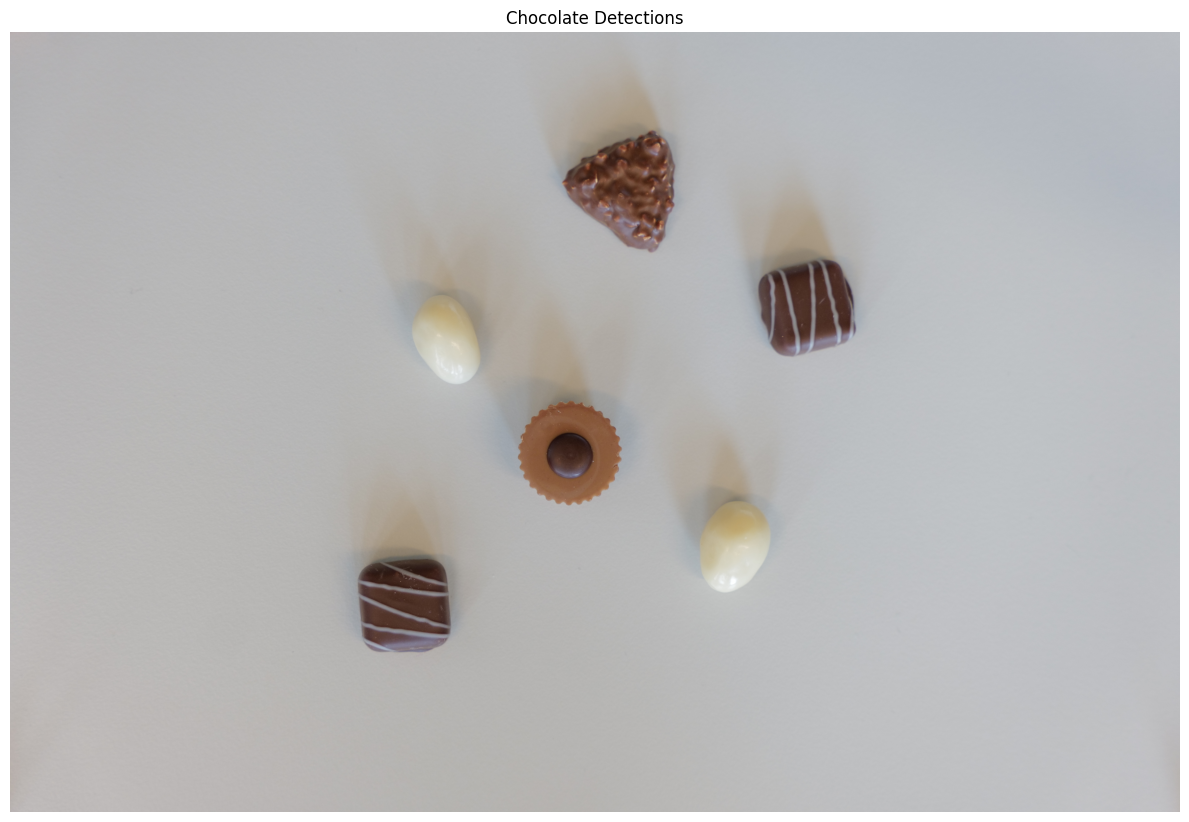

In [32]:
# Create and train the embedding model
embedding_dim = 128
embedding_model = ChocolateEmbeddingNet(embedding_dim=embedding_dim)
dataset = ChocolateEmbeddingDataset("/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train model
trained_model = train_embedding_model(
    embedding_model,
    dataset,
    num_epochs=30,
    batch_size=16,
    learning_rate=1e-4
)

# Compute reference embeddings
ref_embeddings = compute_reference_embeddings(
    trained_model,
    "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates",
    device
)

# Detect chocolates in a test image
test_image_path = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
detections = detect_chocolates(
    trained_model,
    ref_embeddings,
    test_image_path,
    device,
    window_size=64,
    stride=32,
    threshold=0.7,
    apply_preprocessing=True
)

# Visualize results
visualize_detections(test_image_path, detections)

In [33]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super().__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        # Euclidean distances
        pos_dist = F.pairwise_distance(anchor, positive)
        neg_dist = F.pairwise_distance(anchor, negative)
        
        # Loss: max(0, d(a,p) - d(a,n) + margin)
        loss = F.relu(pos_dist - neg_dist + self.margin)
        return loss.mean()

In [34]:
class ChocolateTripletDataset(Dataset):
    def __init__(self, crop_dir, transform=None):
        self.crop_dir = crop_dir
        self.files = sorted([f for f in os.listdir(crop_dir) if f.endswith(".pt")])

        self.label_to_files = {}
        for f in self.files:
            label = f.split("_")[0]
            self.label_to_files.setdefault(label, []).append(f)

        self.labels = list(self.label_to_files.keys())
        self.transform = transform or transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        ])

    def __len__(self):
        return 1000  # generate 1000 random triplets on-the-fly

    def __getitem__(self, _):
        anchor_label = random.choice(self.labels)
        anchor_files = self.label_to_files[anchor_label]
        anchor_file = random.choice(anchor_files)

        # Positive: another from same label or augmented version
        pos_file = anchor_file
        while pos_file == anchor_file and len(anchor_files) > 1:
            pos_file = random.choice(anchor_files)

        # Negative: from a different label
        neg_label = random.choice([l for l in self.labels if l != anchor_label])
        neg_file = random.choice(self.label_to_files[neg_label])

        # Load all 3 crops
        anchor = torch.load(os.path.join(self.crop_dir, anchor_file))
        positive = torch.load(os.path.join(self.crop_dir, pos_file))
        negative = torch.load(os.path.join(self.crop_dir, neg_file))

        # Apply augmentation if provided
        if self.transform:
            anchor = self.transform(anchor)
            positive = self.transform(positive)
            negative = self.transform(negative)

        return anchor, positive, negative

In [35]:
def train_triplet_model(model, dataset, num_epochs=20, batch_size=8, learning_rate=1e-4):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    
    # Create data loader
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    # Define optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    # Create loss function
    criterion = TripletLoss(margin=0.5)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for anchor, positive, negative in dataloader:
            anchor = anchor.to(device)
            positive = positive.to(device)
            negative = negative.to(device)
            
            # Forward pass
            anchor_embed = model(anchor)
            pos_embed = model(positive)
            neg_embed = model(negative)
            
            # Compute loss
            loss = criterion(anchor_embed, pos_embed, neg_embed)
            
            # Backward pass and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            print(f"Batch loss: {loss.item():.4f}", end="\r")
        
        # Print statistics
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")
    
    print("Training complete!")
    return model

In [36]:
# Create model and dataset
embedding_dim = 128
embedding_model = ChocolateEmbeddingNet(embedding_dim=embedding_dim)
crop_dir = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates"
triplet_dataset = ChocolateTripletDataset(crop_dir)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Check if the dataset works
print(f"Dataset contains {len(triplet_dataset)} triplets")
anchor, positive, negative = triplet_dataset[0]
print(f"Anchor shape: {anchor.shape}, Positive shape: {positive.shape}, Negative shape: {negative.shape}")

# Train the model
trained_model = train_triplet_model(
    embedding_model,
    triplet_dataset,
    num_epochs=20,
    batch_size=8,
    learning_rate=1e-4
)

# Save the model
torch.save(trained_model.state_dict(), "chocolate_embedding_model.pth")

Dataset contains 1000 triplets
Anchor shape: torch.Size([3, 64, 64]), Positive shape: torch.Size([3, 64, 64]), Negative shape: torch.Size([3, 64, 64])
Epoch 1/20, Loss: 0.0639
Epoch 2/20, Loss: 0.0300
Epoch 3/20, Loss: 0.0265
Epoch 4/20, Loss: 0.0193
Epoch 5/20, Loss: 0.0124
Epoch 6/20, Loss: 0.0096
Epoch 7/20, Loss: 0.0246
Epoch 8/20, Loss: 0.0227
Epoch 9/20, Loss: 0.0391
Epoch 10/20, Loss: 0.0157
Epoch 11/20, Loss: 0.0217
Epoch 12/20, Loss: 0.0060
Epoch 13/20, Loss: 0.0101
Epoch 14/20, Loss: 0.0142
Epoch 15/20, Loss: 0.0074
Epoch 16/20, Loss: 0.0037
Epoch 17/20, Loss: 0.0075
Epoch 18/20, Loss: 0.0094
Epoch 19/20, Loss: 0.0103
Epoch 20/20, Loss: 0.0055
Training complete!


In [37]:
def test_detection_on_image(model_path, crop_dir, test_image_path):
    """Test chocolate detection on a single image"""
    print(f"Testing detection on image: {test_image_path}")
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = ChocolateEmbeddingNet(embedding_dim=128)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Compute reference embeddings
    print("Computing reference embeddings...")
    ref_embeddings = compute_reference_embeddings(model, crop_dir, device)
    print(f"Generated embeddings for {len(ref_embeddings)} chocolate types")
    
    # Run detection
    print("Detecting chocolates...")
    detections = detect_chocolates_in_scene(
        model=model,
        reference_embeddings=ref_embeddings,
        image_path=test_image_path,
        device=device,
        window_size=64,
        stride=32,
        threshold=0.75
    )
    
    # Print detection results
    print(f"Found {len(detections)} potential chocolates")
    for i, (x, y, label, score) in enumerate(detections[:5]):  # Show top 5
        print(f"  {i+1}. {label} at ({x}, {y}) with score {score:.4f}")
    
    # Return the detection results
    return detections

In [38]:
def detect_chocolates_in_scene(model, reference_embeddings, image_path, device,
                              window_size=64, stride=32, threshold=0.75):
    """
    Detect chocolates in a scene using embedding similarity.
    """
    # Load and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img_rgb.shape[:2]
    
    # Transform for image patches
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((window_size, window_size)),
        transforms.ToTensor()
    ])
    
    detections = []
    
    # Slide window across image
    print("Scanning image...")
    with torch.no_grad():
        for y in range(0, h - window_size + 1, stride):
            for x in range(0, w - window_size + 1, stride):
                # Extract patch
                patch = img_rgb[y:y+window_size, x:x+window_size]
                
                # Skip if patch is too dark (likely background)
                if np.mean(patch) < 10:
                    continue
                
                # Convert to tensor and get embedding
                patch_tensor = transform(patch).unsqueeze(0).to(device)
                embedding = model(patch_tensor).squeeze()
                
                # Compare with reference embeddings
                for label, ref_embedding in reference_embeddings.items():
                    similarity = F.cosine_similarity(
                        embedding.unsqueeze(0), 
                        ref_embedding.to(device).unsqueeze(0)
                    ).item()
                    
                    if similarity > threshold:
                        detections.append((x, y, label, similarity))
    
    # Sort by confidence and keep top matches
    detections = sorted(detections, key=lambda x: x[3], reverse=True)[:20]
    
    # Visualize results
    fig, ax = plt.subplots(figsize=(12, 10))
    ax.imshow(img_rgb)
    
    for x, y, label, score in detections:
        rect = patches.Rectangle(
            (x, y), window_size, window_size,
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x, y-5, f"{label} ({score:.2f})",
            color='black', fontsize=8, backgroundcolor='lime'
        )
    
    plt.title("Chocolate Detections")
    plt.axis('off')
    plt.show()
    
    return detections

Testing detection on image: /Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG
Computing reference embeddings...
Generated embeddings for 11 chocolate types
Detecting chocolates...
Scanning image...


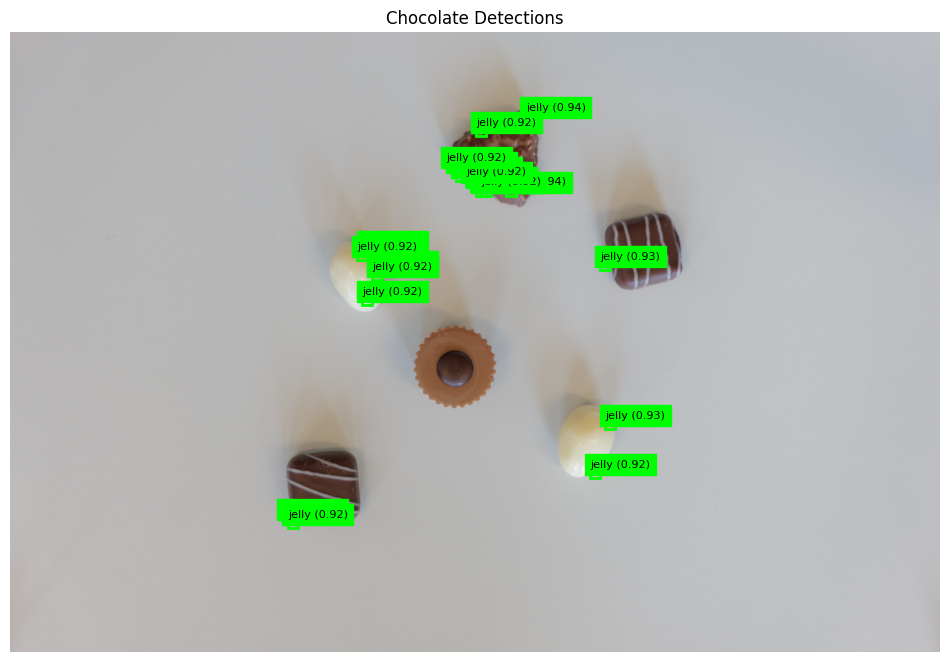

Found 20 potential chocolates
  1. jelly at (2272, 1376) with score 0.9391
  2. jelly at (3328, 512) with score 0.9385
  3. jelly at (3200, 992) with score 0.9377
  4. jelly at (2880, 896) with score 0.9349
  5. jelly at (2848, 864) with score 0.9299


In [39]:
# Check if the model file exists
model_path = "chocolate_embedding_model.pth"
if not os.path.exists(model_path):
    print("No saved model found. Please train the model first.")
else:
    # Run detection test
    crop_dir = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates"
    test_image = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
    
    detections = test_detection_on_image(model_path, crop_dir, test_image)

In [40]:
def detect_chocolates_multi_scale(model, reference_embeddings, image_path, device,
                               base_size=64, scales=[0.75, 1.0, 1.5], stride_fraction=0.5,
                               threshold=0.7):
    """
    Detect chocolates using a multi-scale sliding window approach.
    
    Args:
        model: The embedding model
        reference_embeddings: Dictionary of reference embeddings for each chocolate type
        image_path: Path to the test image
        device: Computation device (cuda/cpu)
        base_size: Base window size
        scales: List of scales to try (relative to base_size)
        stride_fraction: Stride as a fraction of window size
        threshold: Similarity threshold for detection
    """
    # Load and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original image dimensions
    h, w = img_rgb.shape[:2]
    print(f"Image dimensions: {w}x{h}")
    
    # Base transform components
    transform_base = [
        transforms.ToPILImage(),
        transforms.ToTensor()
    ]
    
    all_detections = []
    
    # Process each scale
    for scale in scales:
        window_size = int(base_size * scale)
        stride = int(window_size * stride_fraction)
        
        print(f"Processing scale {scale:.2f} (window size: {window_size}, stride: {stride})")
        
        # Create transform for this scale
        transform = transforms.Compose([
            *transform_base,
            transforms.Resize((base_size, base_size))
        ])
        
        # Don't process if window is bigger than image
        if window_size > min(h, w):
            print(f"  Skipping - window size {window_size} too large for image")
            continue
        
        # Slide window across image
        detections_at_scale = []
        with torch.no_grad():
            for y in range(0, h - window_size + 1, stride):
                for x in range(0, w - window_size + 1, stride):
                    # Extract patch
                    patch = img_rgb[y:y+window_size, x:x+window_size]
                    
                    # Skip if patch is too dark or low contrast
                    if np.mean(patch) < 10 or np.std(patch) < 15:
                        continue
                    
                    # Convert to tensor and get embedding
                    patch_tensor = transform(patch).unsqueeze(0).to(device)
                    embedding = model(patch_tensor).squeeze()
                    
                    # Compare with reference embeddings
                    for label, ref_embedding in reference_embeddings.items():
                        similarity = F.cosine_similarity(
                            embedding.unsqueeze(0), 
                            ref_embedding.to(device).unsqueeze(0)
                        ).item()
                        
                        if similarity > threshold:
                            # Store with original coordinates and size
                            detections_at_scale.append((x, y, label, similarity, window_size, window_size))
        
        print(f"  Found {len(detections_at_scale)} potential detections at scale {scale:.2f}")
        all_detections.extend(detections_at_scale)
    
    # Apply non-max suppression across all scales
    filtered_detections = non_max_suppression(all_detections, iou_threshold=0.3)
    print(f"After NMS: {len(filtered_detections)} final detections")
    
    # Visualize results
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.imshow(img_rgb)
    
    for x, y, label, score, width, height in filtered_detections:
        rect = patches.Rectangle(
            (x, y), width, height, 
            linewidth=2, edgecolor='lime', facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x, y-5, f"{label} ({score:.2f})",
            color='white', fontsize=10, 
            bbox=dict(facecolor='green', alpha=0.8)
        )
    
    plt.title("Chocolate Detections")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return filtered_detections

In [41]:
def test_multi_scale_detection(model_path, crop_dir, test_image_path):
    """Test multi-scale chocolate detection on a single image"""
    print(f"Testing multi-scale detection on image: {test_image_path}")
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = ChocolateEmbeddingNet(embedding_dim=128)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Compute reference embeddings
    print("Computing reference embeddings...")
    ref_embeddings = compute_reference_embeddings(model, crop_dir, device)
    print(f"Generated embeddings for {len(ref_embeddings)} chocolate types")
    
    # Run detection with multiple scales
    print("Detecting chocolates with multiple scales...")
    detections = detect_chocolates_multi_scale(
        model=model,
        reference_embeddings=ref_embeddings,
        image_path=test_image_path,
        device=device,
        base_size=64,
        scales=[0.75, 1.0, 1.25, 1.5, 2.0],  # Try different scales
        stride_fraction=0.25,  # Smaller stride for better coverage
        threshold=0.6  # Slightly lower threshold
    )
    
    return detections

Testing multi-scale detection on image: /Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG
Computing reference embeddings...
Generated embeddings for 11 chocolate types
Detecting chocolates with multiple scales...
Image dimensions: 6000x4000
Processing scale 0.75 (window size: 48, stride: 12)
  Found 37908 potential detections at scale 0.75
Processing scale 1.00 (window size: 64, stride: 16)
  Found 23203 potential detections at scale 1.00
Processing scale 1.25 (window size: 80, stride: 20)
  Found 15897 potential detections at scale 1.25
Processing scale 1.50 (window size: 96, stride: 24)
  Found 11634 potential detections at scale 1.50
Processing scale 2.00 (window size: 128, stride: 32)
  Found 7206 potential detections at scale 2.00
After NMS: 1541 final detections


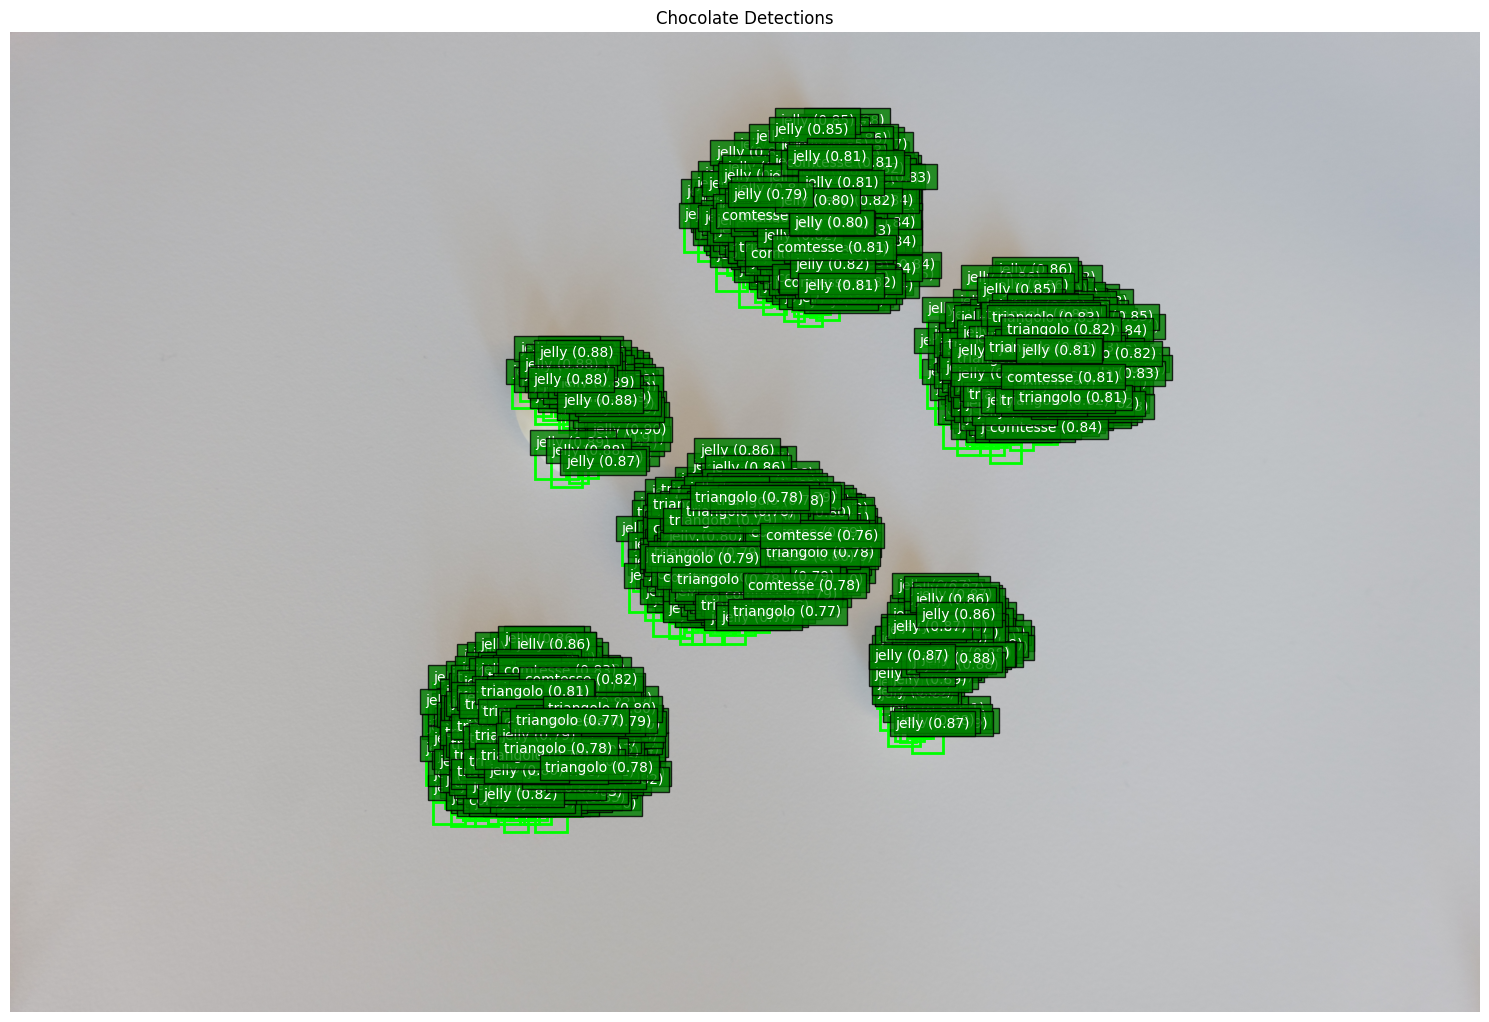

In [42]:
# Check if the model file exists
model_path = "chocolate_embedding_model.pth"
if not os.path.exists(model_path):
    print("No saved model found. Please train the model first.")
else:
    # Run multi-scale detection test
    crop_dir = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates"
    test_image = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
    
    detections = test_multi_scale_detection(model_path, crop_dir, test_image)

In [43]:
def detect_chocolates_improved(model, reference_embeddings, image_path, device,
                               base_size=64, scales=[1.0, 1.5, 2.0], 
                               stride_fraction=0.5, threshold=0.7):
    """
    Improved chocolate detection with better non-maximum suppression.
    """
    # Load and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original image dimensions
    h, w = img_rgb.shape[:2]
    print(f"Image dimensions: {w}x{h}")
    
    # Base transform components
    transform_base = [
        transforms.ToPILImage(),
        transforms.ToTensor()
    ]
    
    all_detections = []
    
    # Process each scale
    for scale in scales:
        window_size = int(base_size * scale)
        stride = int(window_size * stride_fraction)
        
        print(f"Processing scale {scale:.2f} (window size: {window_size}, stride: {stride})")
        
        # Create transform for this scale
        transform = transforms.Compose([
            *transform_base,
            transforms.Resize((base_size, base_size))
        ])
        
        # Don't process if window is bigger than image
        if window_size > min(h, w):
            print(f"  Skipping - window size {window_size} too large for image")
            continue
        
        # Slide window across image
        detections_at_scale = []
        with torch.no_grad():
            for y in range(0, h - window_size + 1, stride):
                for x in range(0, w - window_size + 1, stride):
                    # Extract patch
                    patch = img_rgb[y:y+window_size, x:x+window_size]
                    
                    # Skip if patch is too dark or low contrast
                    if np.mean(patch) < 15 or np.std(patch) < 20:
                        continue
                    
                    # Convert to tensor and get embedding
                    patch_tensor = transform(patch).unsqueeze(0).to(device)
                    embedding = model(patch_tensor).squeeze()
                    
                    # Compare with reference embeddings
                    best_match = None
                    best_score = 0
                    
                    for label, ref_embedding in reference_embeddings.items():
                        similarity = F.cosine_similarity(
                            embedding.unsqueeze(0), 
                            ref_embedding.to(device).unsqueeze(0)
                        ).item()
                        
                        # Only keep the best match per window
                        if similarity > threshold and similarity > best_score:
                            best_score = similarity
                            best_match = (x, y, label, similarity, window_size, window_size)
                    
                    if best_match:
                        detections_at_scale.append(best_match)
        
        print(f"  Found {len(detections_at_scale)} potential detections at scale {scale:.2f}")
        all_detections.extend(detections_at_scale)
    
    # Filter detections by confidence before NMS 
    confidence_threshold = 0.75  # Stricter confidence threshold
    all_detections = [d for d in all_detections if d[3] >= confidence_threshold]
    print(f"After confidence filtering: {len(all_detections)} detections")
    
    # Apply non-max suppression with more aggressive IoU threshold
    filtered_detections = non_max_suppression(all_detections, iou_threshold=0.2)
    print(f"After NMS: {len(filtered_detections)} final detections")
    
    # Group remaining detections by class
    detections_by_class = {}
    for detection in filtered_detections:
        x, y, label, score, width, height = detection
        if label not in detections_by_class:
            detections_by_class[label] = []
        detections_by_class[label].append(detection)
    
    # Visualize results with one color per class
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.imshow(img_rgb)
    
    # Color map for different classes
    unique_labels = sorted(detections_by_class.keys())
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Plot detections by class
    for label, detections in detections_by_class.items():
        color = color_map[label]
        for x, y, _, score, width, height in detections:
            rect = patches.Rectangle(
                (x, y), width, height, 
                linewidth=2, edgecolor=color, facecolor='none'
            )
            ax.add_patch(rect)
            ax.text(
                x, y-5, f"{label} ({score:.2f})",
                color='white', fontsize=10, 
                bbox=dict(facecolor=color, alpha=0.8)
            )
    
    plt.title("Chocolate Detections")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return filtered_detections

In [44]:
def test_improved_detection(model_path, crop_dir, test_image_path):
    """Test improved chocolate detection on a single image"""
    print(f"Testing improved detection on image: {test_image_path}")
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = ChocolateEmbeddingNet(embedding_dim=128)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Compute reference embeddings
    print("Computing reference embeddings...")
    ref_embeddings = compute_reference_embeddings(model, crop_dir, device)
    print(f"Generated embeddings for {len(ref_embeddings)} chocolate types")
    
    # Run improved detection
    print("Detecting chocolates with improved algorithm...")
    detections = detect_chocolates_improved(
        model=model,
        reference_embeddings=ref_embeddings,
        image_path=test_image_path,
        device=device,
        base_size=96,  # Larger base window
        scales=[1.0, 1.5, 2.0],  # Fewer scales
        stride_fraction=0.5,
        threshold=0.7
    )
    
    return detections

Testing improved detection on image: /Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG
Computing reference embeddings...
Generated embeddings for 11 chocolate types
Detecting chocolates with improved algorithm...
Image dimensions: 6000x4000
Processing scale 1.00 (window size: 96, stride: 48)
  Found 510 potential detections at scale 1.00
Processing scale 1.50 (window size: 144, stride: 72)
  Found 269 potential detections at scale 1.50
Processing scale 2.00 (window size: 192, stride: 96)
  Found 174 potential detections at scale 2.00
After confidence filtering: 951 detections
After NMS: 194 final detections


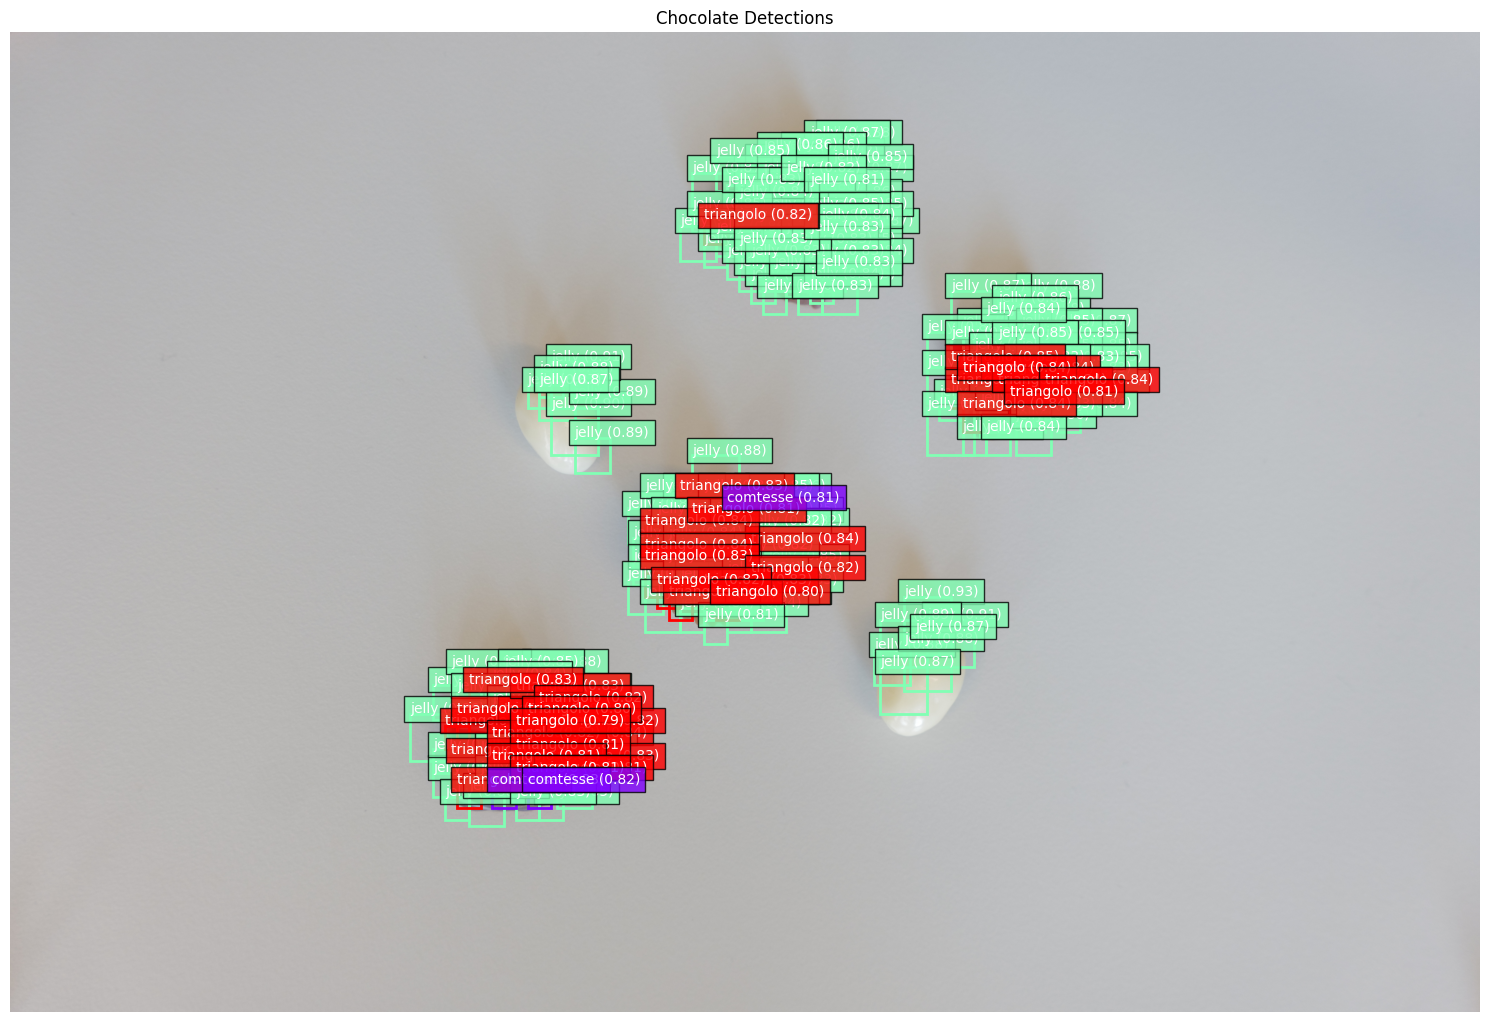

In [45]:
# Check if the model file exists
model_path = "chocolate_embedding_model.pth"
if not os.path.exists(model_path):
    print("No saved model found. Please train the model first.")
else:
    # Run improved detection
    crop_dir = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates"
    test_image = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000756.JPG"
    
    detections = test_improved_detection(model_path, crop_dir, test_image)

In [46]:
def detect_chocolates_final(model, reference_embeddings, image_path, device,
                            base_size=128, scales=[1.0, 1.5, 2.0], 
                            stride_fraction=0.25, threshold=0.8):
    """
    Final improved chocolate detection with optimized parameters.
    """
    # Load and prepare image
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Original image dimensions
    h, w = img_rgb.shape[:2]
    print(f"Image dimensions: {w}x{h}")
    
    # Base transform components
    transform_base = [
        transforms.ToPILImage(),
        transforms.ToTensor()
    ]
    
    all_detections = []
    
    # Process each scale
    for scale in scales:
        window_size = int(base_size * scale)
        stride = int(window_size * stride_fraction)
        
        print(f"Processing scale {scale:.2f} (window size: {window_size}, stride: {stride})")
        
        # Create transform for this scale
        transform = transforms.Compose([
            *transform_base,
            transforms.Resize((base_size, base_size))
        ])
        
        # Don't process if window is bigger than image
        if window_size > min(h, w):
            print(f"  Skipping - window size {window_size} too large for image")
            continue
        
        # Slide window across image
        detections_at_scale = []
        with torch.no_grad():
            for y in range(0, h - window_size + 1, stride):
                for x in range(0, w - window_size + 1, stride):
                    # Extract patch
                    patch = img_rgb[y:y+window_size, x:x+window_size]
                    
                    # Skip if patch is too dark or low contrast
                    if np.mean(patch) < 20 or np.std(patch) < 25:
                        continue
                    
                    # Convert to tensor and get embedding
                    patch_tensor = transform(patch).unsqueeze(0).to(device)
                    embedding = model(patch_tensor).squeeze()
                    
                    # Compare with reference embeddings
                    best_match = None
                    best_score = 0
                    
                    for label, ref_embedding in reference_embeddings.items():
                        similarity = F.cosine_similarity(
                            embedding.unsqueeze(0), 
                            ref_embedding.to(device).unsqueeze(0)
                        ).item()
                        
                        # Only keep the best match per window
                        if similarity > threshold and similarity > best_score:
                            best_score = similarity
                            best_match = (x, y, label, similarity, window_size, window_size)
                    
                    if best_match:
                        detections_at_scale.append(best_match)
        
        print(f"  Found {len(detections_at_scale)} potential detections at scale {scale:.2f}")
        all_detections.extend(detections_at_scale)
    
    # Filter detections by confidence before NMS 
    confidence_threshold = 0.85  # Higher confidence threshold
    all_detections = [d for d in all_detections if d[3] >= confidence_threshold]
    print(f"After confidence filtering: {len(all_detections)} detections")
    
    # Apply class-aware non-max suppression
    final_detections = []
    
    # Group by class first
    class_detections = {}
    for det in all_detections:
        label = det[2]
        if label not in class_detections:
            class_detections[label] = []
        class_detections[label].append(det)
    
    # Process each class separately
    for label, dets in class_detections.items():
        # Apply very aggressive NMS within each class
        filtered = non_max_suppression(dets, iou_threshold=0.1)
        final_detections.extend(filtered)
    
    print(f"After class-based NMS: {len(final_detections)} final detections")
    
    # One final filtering step to remove small detections inside larger ones
    # (often happens with different classes)
    final_detections = remove_contained_boxes(final_detections, containment_threshold=0.8)
    print(f"After containment filtering: {len(final_detections)} final detections")
    
    # Visualize results with one color per class
    fig, ax = plt.subplots(figsize=(15, 12))
    ax.imshow(img_rgb)
    
    # Color map for different classes
    unique_labels = sorted(set(d[2] for d in final_detections))
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_labels)))
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}
    
    # Plot detections by class
    for x, y, label, score, width, height in final_detections:
        color = color_map[label]
        rect = patches.Rectangle(
            (x, y), width, height, 
            linewidth=3, edgecolor=color, facecolor='none'
        )
        ax.add_patch(rect)
        ax.text(
            x, y-10, f"{label} ({score:.2f})",
            color='white', fontsize=12, 
            bbox=dict(facecolor=color, alpha=0.9)
        )
    
    plt.title("Chocolate Detections")
    plt.axis('off')
    plt.tight_layout()
    plt.show()
    
    return final_detections

def remove_contained_boxes(detections, containment_threshold=0.8):
    """
    Remove boxes that are mostly contained within larger boxes.
    
    Args:
        detections: List of (x, y, label, score, width, height)
        containment_threshold: If a box's area is contained within another by this fraction, remove it
    """
    if not detections:
        return []
    
    # Sort by score (highest first)
    detections = sorted(detections, key=lambda x: x[3], reverse=True)
    
    keep = []
    removed = []
    
    for i, det1 in enumerate(detections):
        # Skip if already marked for removal
        if i in removed:
            continue
            
        keep.append(det1)
        x1, y1, _, _, w1, h1 = det1
        
        # Compare with all other detections
        for j, det2 in enumerate(detections):
            if i == j or j in removed:
                continue
                
            x2, y2, _, _, w2, h2 = det2
            
            # Calculate intersection area
            x_left = max(x1, x2)
            y_top = max(y1, y2)
            x_right = min(x1 + w1, x2 + w2)
            y_bottom = min(y1 + h1, y2 + h2)
            
            # No overlap
            if x_right < x_left or y_bottom < y_top:
                continue
                
            intersection = (x_right - x_left) * (y_bottom - y_top)
            area2 = w2 * h2
            
            # If box2 is mostly contained within box1, mark it for removal
            if intersection / area2 > containment_threshold:
                removed.append(j)
    
    return keep

In [47]:
def test_final_detection(model_path, crop_dir, test_image_path):
    """Test the final optimized chocolate detection"""
    print(f"Testing final optimized detection on image: {test_image_path}")
    
    # Setup device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    # Load model
    model = ChocolateEmbeddingNet(embedding_dim=128)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model = model.to(device)
    model.eval()
    
    # Compute reference embeddings
    print("Computing reference embeddings...")
    ref_embeddings = compute_reference_embeddings(model, crop_dir, device)
    print(f"Generated embeddings for {len(ref_embeddings)} chocolate types")
    
    # Run final detection
    print("Detecting chocolates with final optimized algorithm...")
    detections = detect_chocolates_final(
        model=model,
        reference_embeddings=ref_embeddings,
        image_path=test_image_path,
        device=device,
        base_size=192,      # Much larger base window
        scales=[0.75, 1.0], # Limited scales
        stride_fraction=0.25,
        threshold=0.8       # Higher similarity threshold
    )
    
    return detections

Testing final optimized detection on image: /Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000909.JPG
Computing reference embeddings...
Generated embeddings for 11 chocolate types
Detecting chocolates with final optimized algorithm...
Image dimensions: 6000x4000
Processing scale 0.75 (window size: 144, stride: 36)
  Found 3341 potential detections at scale 0.75
Processing scale 1.00 (window size: 192, stride: 48)
  Found 2091 potential detections at scale 1.00
After confidence filtering: 941 detections
After class-based NMS: 101 final detections
After containment filtering: 101 final detections


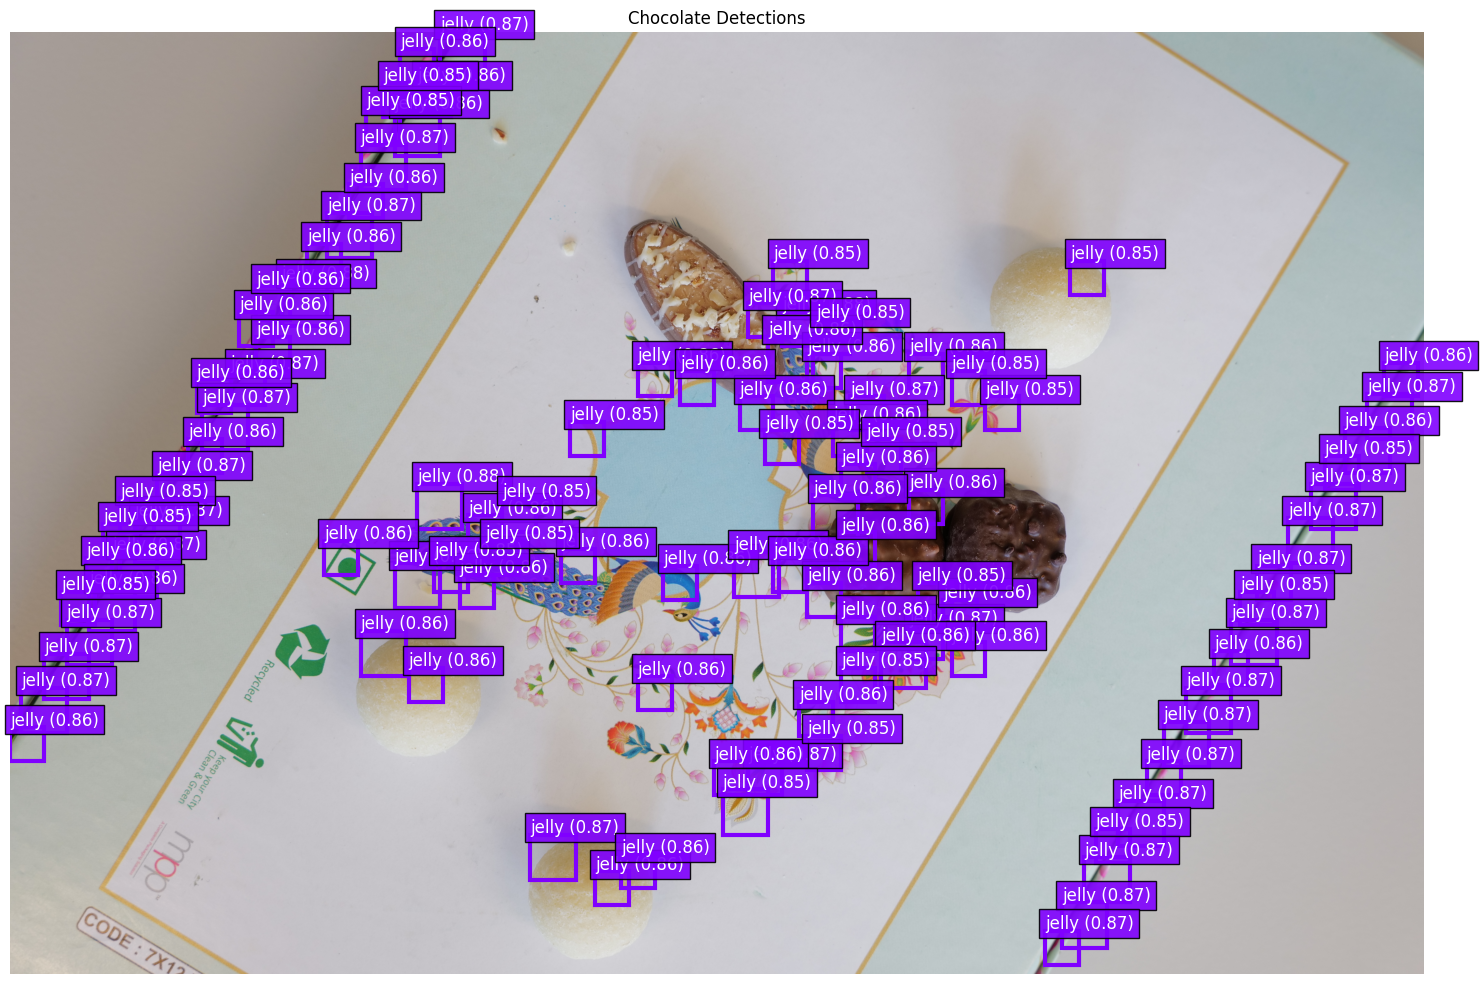

In [49]:
# Check if the model file exists
model_path = "chocolate_embedding_model.pth"
if not os.path.exists(model_path):
    print("No saved model found. Please train the model first.")
else:
    # Run final optimized detection
    crop_dir = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/crops_chocolates"
    test_image = "/Users/sherwood/Desktop/study/EPFL/IM/project/dataset_project_iapr2025/train/L1000909.JPG"
    
    detections = test_final_detection(model_path, crop_dir, test_image)